# CPTox21: Conformal prediction and exchangeability in in vitro toxicological datasets



In this notebook, it is shown how the experiments for the CPTox21 manuscript (train model and make predictions with Tox21 data, update the training and/or calibration set) are run for multiple endpoints. Furthermore the evaluation over all enpoints in the form of boxplots is provided.

### Import libraries and modules

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
from sklearn.svm import SVC
from nonconformist.nc import NcFactory, MarginErrFunc
import matplotlib.pyplot as plt

In [3]:
from cptox21 import (
    define_path, load_signatures_files, InductiveConformalPredictor,
    CPTox21AggregatedConformalPredictor, AggregatedConformalPredictor, 
    StratifiedRatioSampler, CrossValidationSampler, KnownIndicesSampler,
    CPTox21CrossValidator, CPTox21TrainUpdateCrossValidator
)

In [4]:
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(
    filename='test_logger.log',
    filemode='w',
    level=logging.INFO)

console = logging.StreamHandler()
console.setLevel(logging.ERROR)
logging.getLogger('').addHandler(console)

### Define paths and parameters

In [5]:
# Paths
data_signatures_path = "../data/data_signatures/"
data_statistics_path = "../data/data_statistics/"
data_statistics_path = "../../../KT-ER/cptox21_pipeline/data/data_curta_200909/"

In [6]:
# Define if model fitting and predictions are required (set to True) or if data are already
# available (set to False)
run_experiment = False #True

In [7]:
# Parameters
n_folds_acp = 3# 10

In [8]:
endpoints = [
    'SR_ATAD5', 'NR_ER', 'NR_AR', 'SR_HSE', 'SR_MMP', 'SR_p53', 'NR_Aromatase',
    'SR_ARE', 'NR_AR_LBD', 'NR_AhR', 'NR_ER_LBD', 'NR_PPAR_gamma'
]

### Define functions

In [9]:
def load_data(endpoint):
    """
    Load signature datasets per endpoint
    
    Parameters
    ----------
    endpoint : endpoint for which the data should be loaded
    
    Returns
    -------
    X_train : (signature) descriptors for Tox21train set
    y_train : labels for Tox21train set
    X_test : (signature) descriptors for Tox21test set
    y_test : labels for Tox21test set
    X_score : (signature) descriptors for Tox21score set
    y_score : labels for Tox21score set
    
    """
    datasets = ["train", "test", "score"]
    train_path = define_path(endpoint=endpoint, data=datasets[0], signatures_path=data_signatures_path)
    test_path = define_path(endpoint=endpoint, data=datasets[1], signatures_path=data_signatures_path)
    score_path = define_path(endpoint=endpoint, data=datasets[2], signatures_path=data_signatures_path)

    X_train, y_train, X_test, y_test, X_score, y_score = load_signatures_files(train_path, test_path, score_path)
    X_train = X_train[:500]
    y_train = y_train[:500]
    return X_train, y_train, X_test, y_test, X_score, y_score

In [10]:
def cross_validate_compare_calibration_sets(
    endpoint, X_train, y_train, X_test, y_test, X_score, y_score
):
    """
    Perform a crossvalidation, including the following settings:
    * use original training and calibration set (Tox21train): predict internal test set (Tox21train)
    * use original training and calibration set: predict score set (Tox21score)
    * use original training and calibration set: predict test set (Tox21test)
    * update calibration set with Tox21test: predict score set
    * update calibration set with part of Tox21score: predict (other) part of Tox21score
    
    Parameters
    ----------
    endpoint : endpoint for which the data should be loaded
    
    X_train : (signature) descriptors for Tox21train set
    y_train : labels for Tox21train set
    X_test : (signature) descriptors for Tox21test set
    y_test : labels for Tox21test set
    X_score : (signature) descriptors for Tox21score set
    y_score : labels for Tox21score set
    
    Returns
    -------
    cross_validator : cross_validator class with fitted and calibrated models and evaluation dfs
    """
    cross_validator = CPTox21CrossValidator(
            acp, cv_splitter=CrossValidationSampler(),
            score_splitter=StratifiedRatioSampler(test_ratio=0.5)
        )
    cross_validation_dfs = cross_validator.cross_validate(
            steps=10,
            endpoint=endpoint,
            X_train=X_train,
            y_train=y_train,
            X_update=X_test,
            y_update=y_test,
            X_score=X_score,
            y_score=y_score,
        )
    return cross_validator

In [11]:
def cross_validate_with_updated_training_set(
    endpoint, X_train, y_train, X_test, y_test, X_score, y_score, known_indices_sampler
):
    
    """
    Perform a crossvalidation, including the following settings:
    * update original training set (Tox21train) with Tox21test: predict internal test set (Tox21train & Tox21test)
    * update original training set (Tox21train) with Tox21test: predict score set (Tox21score)
        
    Parameters
    ----------
    endpoint : endpoint for which the data should be loaded
    
    X_train : (signature) descriptors for Tox21train set
    y_train : labels for Tox21train set
    X_test : (signature) descriptors for Tox21test set
    y_test : labels for Tox21test set
    X_score : (signature) descriptors for Tox21score set
    y_score : labels for Tox21score set
    
    known_indices_sampler: Sampler to split X_train and y_train in the same train and test sets
    as used (known) for the previous experiments
    
    Returns
    -------
    cross_validator : cross_validator class with fitted and calibrated models and evaluation dfs
    """
    train_update_cross_validator = CPTox21TrainUpdateCrossValidator(
    train_update_acp, cv_splitter=known_indices_sampler
)

    train_update_cross_validation_dfs = train_update_cross_validator.cross_validate(steps=10,
                                           endpoint=endpoint,
                                           X_train=X_train,
                                           y_train=y_train,
                                           X_update=X_test,
                                           y_update=y_test,
                                           X_score=X_score,
                                           y_score=y_score,
                                           class_wise_evaluation=False)
    return train_update_cross_validator

In [12]:
todo: import from cptox21.py!!!!!!

def calculate_deviation_square(error, sl):
    """
    Calculate the square deviation between a given error value and a significance level
    Parameters
    ----------
    error : error
    sl : significance level
    
    Returns
    -------
    square deviation
    
    """
    return (error-sl)**2

In [13]:
def calculate_rmsd_from_df(eval_df, cl=None):
    """
    Calculate the rmsd (root mean square deviation) for all error-significance level pairs
    in a dataframe
    
    Parameters
    ----------
    eval_df : dataframe for which the rmsd should be calculated
    cl : class of compounds for which the rmsd should be calculated, i.e. 0 or 1
    if cl is None, the overall rmsd for all compounds will be calculated.
    
    Returns
    -------
    dataframe with an additional 'rmsd' column
    
    """
    if cl:
        eval_df['square'] = eval_df.apply(lambda row: calculate_deviation_square(
            row[f"error_rate_{cl} mean"],   row["significance_level"]), axis=1)
    else:
        eval_df['square'] = eval_df.apply(lambda row: calculate_deviation_square(
            row["error_rate mean"], row["significance_level"]), axis=1)
    rmsd = np.round(math.sqrt(np.mean(eval_df["square"])), 3)
    
    return rmsd

In [14]:
def calculate_pos_deviation_square(error, sl):
    """
    Calculate the square deviation between a given error value and a significance level
    if the deviation is positive (>0)
    
    Parameters
    ----------
    error : error
    sl : significance level
    
    Returns
    -------
    square deviation or 0
    
    """
   
    if error > sl:
        return (error-sl)**2
    else:

        return 0

In [15]:
def calculate_rmsd_pos_from_df(eval_df, cl=None):
    # fixme: exchange 'rmsd_pos' with a more appropriate term
    """
    Calculate the rmsd (root mean square deviation) for all error-significance level pairs
    in a dataframe if the deviation (error - significance level) is larger than 0
    
    Parameters
    ----------
    eval_df : dataframe for which the rmsd_pos should be calculated
    cl : class of compounds for which the rmsd_pos should be calculated, i.e. 0 or 1
        if cl is None, the overall rmsd_pos for all compounds will be calculated.
    
    Returns
    -------
    dataframe with an additional 'rmsd_pos' column
    
    """
    if cl:
        eval_df['square'] = eval_df.apply(lambda row: calculate_pos_deviation_square(
            row[f"error_rate_{cl} mean"],   row["significance_level"]), axis=1)
    else:
        eval_df['square'] = eval_df.apply(lambda row: calculate_pos_deviation_square(
            row["error_rate mean"], row["significance_level"]), axis=1)
    rmsd_pos = np.round(math.sqrt(np.mean(eval_df["square"])), 3)
    
    return rmsd_pos

In [16]:
def boxplot_rmsd(rmsds, rmsd_title, strategies=None):
    if strategies is None:
        strategies = ["cv_original", "pred_score_original", "pred_score_trainupdate",
              "pred_score_calupdate", "pred_score_calupdate2"]
    """
    Generate a boxplot with the rmsd values over multiple endpoints.
    This function can be used to plot both rmsd or rmsd_pos values.
    
    Parameters
    ----------
    strategies : strategies or set-ups used when making the predictions (e.g. "original_cv")
    rmsds : a dictionary with the strategies as keys and a list of rmsd values for all the
        endpoints as values
    rmsd_title : the naming for 'rmsd' which should be used in the plot title, e.g. "rmsd", "rmsd_pos"
    """
    plt.clf()
    plt.boxplot([rmsds[k] for k in strategies], labels=strategies)
    plt.xticks(rotation='vertical')
    plt.title(f"{rmsd_title} over all endpoints")

### Build conformal predictors

In [17]:
# Build ICP
clf = SVC(kernel='rbf', C=50, gamma=0.002, probability=True)
error_function = MarginErrFunc()
normaliser_model = None
nc = NcFactory.create_nc(clf, err_func=error_function)
icp = InductiveConformalPredictor(
    nc_function=nc, condition=(lambda instance: instance[1])
)  # Mondrian as (default) condition)

In [18]:
# Build ACP (uses original and updated calibration sets)
acp = CPTox21AggregatedConformalPredictor(
        predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp),
        aggregation_func=np.median
    )

In [19]:
# Build ACP (accepts only one calibration set, used with updated training set)
train_update_acp = AggregatedConformalPredictor(
        predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp),
        aggregation_func=np.median
    )

### Run experiments

In [28]:
# fixme: alternatively, if models/predictions already fitted/made, we could load datasets 
# (instead of fitting/predicting everything again)

evaluation_dfs = {"cv_original": [], "pred_score_original": [], "pred_test_original": [],
                  "pred_score_scp": [],
                 "pred_score_calupdate": [], "pred_score_calupdate2": [],
                  "cv_trainupdate": [], "pred_score_trainupdate": []}

for endpoint in endpoints:
    print(endpoint)
    if run_experiment: # If we want to make calculations for all set-ups
        
        X_train, y_train, X_test, y_test, X_score, y_score = load_data(endpoint)
        cptox21_cross_validator = cross_validate_compare_calibration_sets(
            endpoint, X_train, y_train, X_test, y_test, X_score, y_score
        )

        evaluation_dfs["cv_original"].append(cptox21_cross_validator.averaged_evaluation_df_cv)
        evaluation_dfs["pred_score_original"].append(
            cptox21_cross_validator.averaged_evaluation_df_pred_score
        )
        evaluation_dfs["pred_score_calupdate"].append(
            cptox21_cross_validator.averaged_evaluation_df_pred_cal_update
        )
        evaluation_dfs["pred_score_calupdate2"].append(
            cptox21_cross_validator.averaged_evaluation_df_pred_cal_update2
        )
        
        cptox21_cross_validator.averaged_evaluation_df_cv.to_csv(
            f"{data_statistics_path}{endpoint}_cv_original.csv"
        )
        cptox21_cross_validator.averaged_evaluation_df_pred_score.to_csv(
            f"{data_statistics_path}{endpoint}_pred_score_original.csv"
        )
        cptox21_cross_validator.averaged_evaluation_df_pred_test.to_csv(
            f"{data_statistics_path}{endpoint}_pred_test_original.csv"
        )
        cptox21_cross_validator.averaged_evaluation_df_pred_cal_update.to_csv(
            f"{data_statistics_path}{endpoint}_pred_score_calupdate.csv"
        )
        cptox21_cross_validator.averaged_evaluation_df_pred_cal_update2.to_csv(
            f"{data_statistics_path}{endpoint}_pred_score_calupdate2.csv"
        )
        
        train_index, test_index = cptox21_cross_validator.train_indices, cptox21_cross_validator.test_indices
        known_indices_sampler = KnownIndicesSampler(
            known_train=train_index, known_test=test_index
        )

        train_update_cross_validator = cross_validate_with_updated_training_set(
            endpoint, X_train, y_train, X_test, y_test, X_score, y_score, known_indices_sampler
        )

        evaluation_dfs["cv_trainupdate"].append(train_update_cross_validator.averaged_evaluation_df_cv)
        evaluation_dfs["pred_score_trainupdate"].append(train_update_cross_validator.averaged_evaluation_df_pred_score)
    
        train_update_cross_validator.averaged_evaluation_df_cv.to_csv(
            f"{data_statistics_path}{endpoint}_cv_trainupdate.csv"
        )
        train_update_cross_validator.averaged_evaluation_df_pred_score.to_csv(
            f"{data_statistics_path}{endpoint}_pred_score_trainupdate.csv"
        )
#     else: # If results are already available and dataframes can be loaded directly
#         cv_original_df = pd.read_csv(f"{data_statistics_path}{endpoint}_cv_original.csv")
#         evaluation_dfs["cv_original"].append(cv_original_df)
#         pred_score_original_df = pd.read_csv(
#             f"{data_statistics_path}{endpoint}_pred_score_original.csv"
#         )
#         evaluation_dfs["pred_score_original"].append(pred_score_original_df)
#         pred_test_original_df = pd.read_csv(
#             f"{data_statistics_path}{endpoint}_pred_test_original.csv"
#         )
#         pred_score_calupdate_df = pd.read_csv(
#             f"{data_statistics_path}{endpoint}_pred_score_calupdate.csv"
#         )
#         evaluation_dfs["pred_score_calupdate"].append(pred_score_calupdate_df)
#         pred_score_calupdate2_df = pd.read_csv(
#              f"{data_statistics_path}{endpoint}_pred_score_calupdate2.csv"
#         )
#         evaluation_dfs["pred_score_calupdate2"].append(pred_score_calupdate2_df)
#         cv_trainupdate_df = pd.read_csv(
#             f"{data_statistics_path}{endpoint}_cv_trainupdate.csv"
#         )
#         evaluation_dfs["cv_trainupdate"].append(cv_trainupdate_df)
#         pred_score_trainupdate_df = pd.read_csv(
#             f"{data_statistics_path}{endpoint}_pred_score_trainupdate.csv"
#         )
#         evaluation_dfs["pred_score_trainupdate"].append(pred_score_trainupdate_df)
        
    else: # If results are already available and dataframes can be loaded directly
        cv_original_df = pd.read_csv(f"{data_statistics_path}{endpoint}_averaged_eval_df_cv.csv")
        evaluation_dfs["cv_original"].append(cv_original_df)
        pred_score_original_df = pd.read_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_pred_score.csv"
        )
        evaluation_dfs["pred_score_original"].append(pred_score_original_df)
        pred_test_original_df = pd.read_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_pred_test.csv"
        )
        pred_score_scp_df = pd.read_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_pred_score_scp.csv"
        )
        evaluation_dfs["pred_score_scp"].append(pred_score_scp_df)
        pred_score_calupdate_df = pd.read_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_cal_update.csv"
        )
        evaluation_dfs["pred_score_calupdate"].append(pred_score_calupdate_df)
        pred_score_calupdate2_df = pd.read_csv(
             f"{data_statistics_path}{endpoint}_averaged_eval_df_cal_update2.csv"
        )
        evaluation_dfs["pred_score_calupdate2"].append(pred_score_calupdate2_df)
        cv_trainupdate_df = pd.read_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_cv_train_update.csv"
        )
        evaluation_dfs["cv_trainupdate"].append(cv_trainupdate_df)
        pred_score_trainupdate_df = pd.read_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_pred_score_train_update.csv"
        )
        evaluation_dfs["pred_score_trainupdate"].append(pred_score_trainupdate_df)

SR_ATAD5
NR_ER
NR_AR
SR_HSE
SR_MMP
SR_p53
NR_Aromatase
SR_ARE
NR_AR_LBD
NR_AhR
NR_ER_LBD
NR_PPAR_gamma


In [29]:
evaluation_dfs

{'cv_original': [    significance_level  validity mean  validity std  validity_0 mean  \
  0                  0.0         1.0000      0.000000           1.0000   
  1                  0.1         0.9140      0.009772           0.9142   
  2                  0.2         0.8116      0.008355           0.8106   
  3                  0.3         0.7084      0.009889           0.7076   
  4                  0.4         0.6056      0.007092           0.6034   
  5                  0.5         0.4966      0.012361           0.4950   
  6                  0.6         0.3892      0.021052           0.3868   
  7                  0.7         0.2810      0.020298           0.2784   
  8                  0.8         0.1798      0.013755           0.1796   
  9                  0.9         0.0840      0.013748           0.0850   
  10                 1.0         0.0000      0.000000           0.0000   
  
      validity_0 std  validity_1 mean  validity_1 std  error_rate mean  \
  0         0.000000

### Calculate rmsd's for all endpoints over all strategies

In [30]:
rmsds = {}
for k, v in evaluation_dfs.items():
    print(k)
    rmsds[k] = []
    for df in v:
        
        rmsd = calculate_rmsd_from_df(df)
        rmsds[k].append(rmsd)
rmsds

cv_original
pred_score_original
pred_test_original
pred_score_scp
pred_score_calupdate
pred_score_calupdate2
cv_trainupdate
pred_score_trainupdate


{'cv_original': [0.012,
  0.022,
  0.03,
  0.019,
  0.011,
  0.012,
  0.013,
  0.016,
  0.018,
  0.015,
  0.018,
  0.015],
 'pred_score_original': [0.06,
  0.047,
  0.041,
  0.045,
  0.034,
  0.069,
  0.029,
  0.079,
  0.039,
  0.069,
  0.056,
  0.054],
 'pred_test_original': [],
 'pred_score_scp': [0.057,
  0.024,
  0.031,
  0.04,
  0.024,
  0.063,
  0.033,
  0.067,
  0.022,
  0.064,
  0.024,
  0.034],
 'pred_score_calupdate': [0.016,
  0.059,
  0.064,
  0.058,
  0.043,
  0.067,
  0.042,
  0.036,
  0.061,
  0.064,
  0.045,
  0.026],
 'pred_score_calupdate2': [0.015,
  0.016,
  0.027,
  0.015,
  0.013,
  0.025,
  0.023,
  0.015,
  0.019,
  0.022,
  0.021,
  0.021],
 'cv_trainupdate': [0.012,
  0.023,
  0.028,
  0.022,
  0.013,
  0.015,
  0.012,
  0.017,
  0.018,
  0.018,
  0.018,
  0.013],
 'pred_score_trainupdate': [0.065,
  0.04,
  0.033,
  0.037,
  0.023,
  0.058,
  0.027,
  0.067,
  0.033,
  0.06,
  0.039,
  0.046]}

### Calculate rmsd_pos's for all endpoints over all strategies

In [31]:
rmsds_pos = {}
for k, v in evaluation_dfs.items():
    print(k)
    rmsds_pos[k] = []
    for df in v:
        rmsd_pos = calculate_rmsd_pos_from_df(df)
        rmsds_pos[k].append(rmsd_pos)
rmsds_pos

cv_original
pred_score_original
pred_test_original
pred_score_scp
pred_score_calupdate
pred_score_calupdate2
cv_trainupdate
pred_score_trainupdate


{'cv_original': [0.01,
  0.019,
  0.028,
  0.014,
  0.009,
  0.008,
  0.012,
  0.013,
  0.016,
  0.011,
  0.016,
  0.013],
 'pred_score_original': [0.06,
  0.047,
  0.041,
  0.045,
  0.034,
  0.069,
  0.029,
  0.079,
  0.039,
  0.069,
  0.056,
  0.054],
 'pred_test_original': [],
 'pred_score_scp': [0.057,
  0.024,
  0.031,
  0.04,
  0.024,
  0.063,
  0.032,
  0.067,
  0.022,
  0.064,
  0.024,
  0.034],
 'pred_score_calupdate': [0.0,
  0.008,
  0.004,
  0.052,
  0.022,
  0.0,
  0.027,
  0.026,
  0.0,
  0.009,
  0.004,
  0.003],
 'pred_score_calupdate2': [0.013,
  0.015,
  0.02,
  0.015,
  0.003,
  0.025,
  0.023,
  0.011,
  0.018,
  0.02,
  0.017,
  0.02],
 'cv_trainupdate': [0.009,
  0.018,
  0.025,
  0.017,
  0.009,
  0.008,
  0.01,
  0.013,
  0.014,
  0.011,
  0.014,
  0.011],
 'pred_score_trainupdate': [0.065,
  0.04,
  0.032,
  0.037,
  0.023,
  0.058,
  0.027,
  0.067,
  0.033,
  0.06,
  0.039,
  0.046]}

### Plot boxplot

In [32]:
strategies = ["cv_original", "pred_score_original", "pred_score_scp",
#               "cv_trainupdate",
              "pred_score_trainupdate",
              "pred_score_calupdate", "pred_score_calupdate2"]

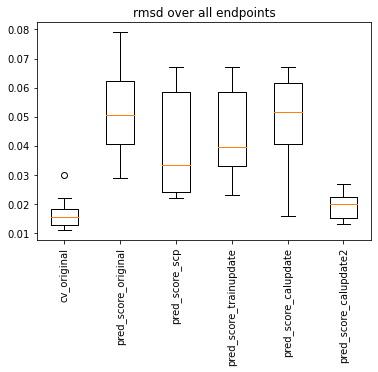

In [33]:
boxplot_rmsd(rmsds, "rmsd", strategies)

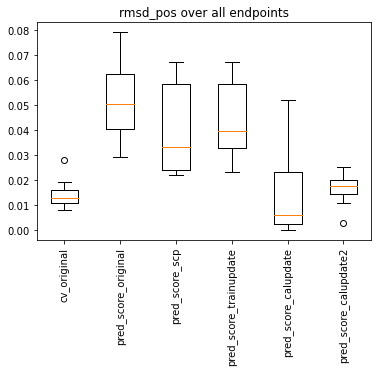

In [34]:
boxplot_rmsd(rmsds_pos, "rmsd_pos", strategies)

In [35]:
def scatter_rmsd(rmsds, rmsd_title, strategies=None):
    if strategies is None:
        strategies = ["cv_original", "pred_score_original", "pred_score_trainupdate",
              "pred_score_calupdate", "pred_score_calupdate2"]
    """
    Generate a boxplot with the rmsd values over multiple endpoints.
    This function can be used to plot both rmsd or rmsd_pos values.
    
    Parameters
    ----------
    strategies : strategies or set-ups used when making the predictions (e.g. "original_cv")
    rmsds : a dictionary with the strategies as keys and a list of rmsd values for all the
        endpoints as values
    rmsd_title : the naming for 'rmsd' which should be used in the plot title, e.g. "rmsd", "rmsd_pos"
    """
    plt.clf()
    for s in strategies:
        plt.scatter([rmsds[k] for k in strategies], s)#, labels=strategies)
    plt.xticks(rotation='vertical')
    plt.title(f"{rmsd_title} over all endpoints")

In [36]:
def line_plot(rmsds, strategies, colours=None, markers=None):
    plt.clf()
    fig = plt.figure(figsize=(10,20))
    if colours is None:
        colours = ['navy', 'royalblue', 'blueviolet', 'plum', 'mediumvioletred', 'red', 'coral', 'gold', 'yellowgreen', 'green', 'paleturquoise', 'slategrey']
    if markers is None:
        markers = ['3', '<', '>', 'x', 's', '+', 'd', 'h', '*', '1', 'o', 'D']
    for i, ep in enumerate(endpoints):
    
        plt.plot(strategies, [rmsds[s][i] for s in strategies], color=colours[i], linewidth=0.5)#, marker='-o')
        plt.scatter(strategies, [rmsds[s][i] for s in strategies], label=ep, color=colours[i], marker=markers[i], s=50)
        plt.xticks(rotation='vertical')
        plt.legend(endpoints, loc='upper right')#, bbox_to_anchor=(1, 0.5))
    

<Figure size 432x288 with 0 Axes>

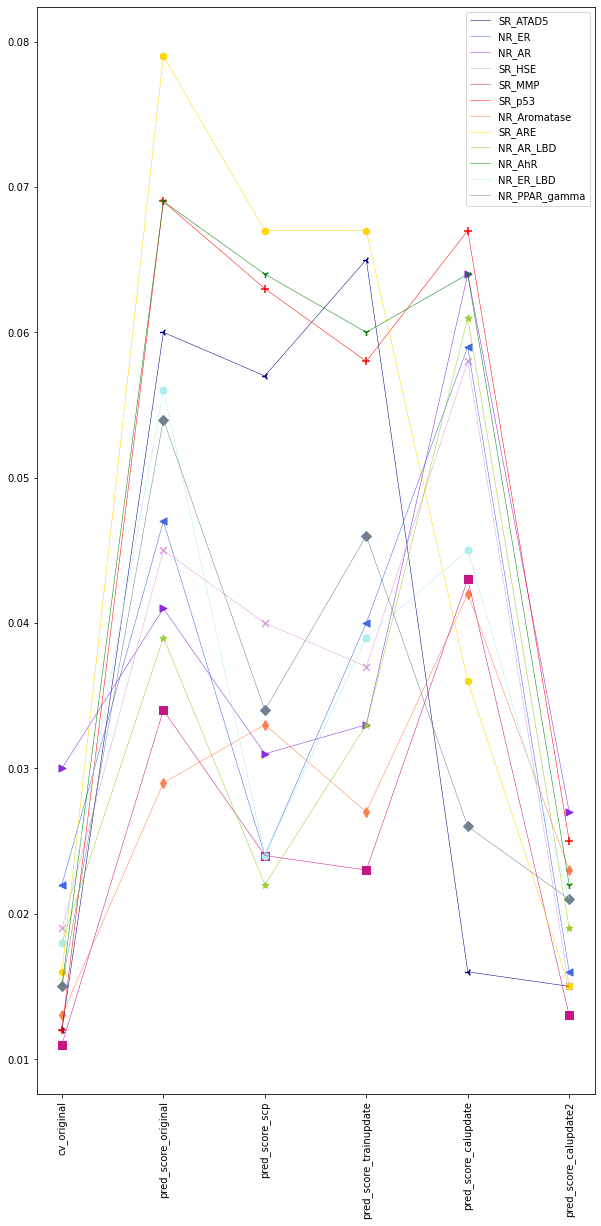

In [37]:
line_plot(rmsds, strategies)

<Figure size 432x288 with 0 Axes>

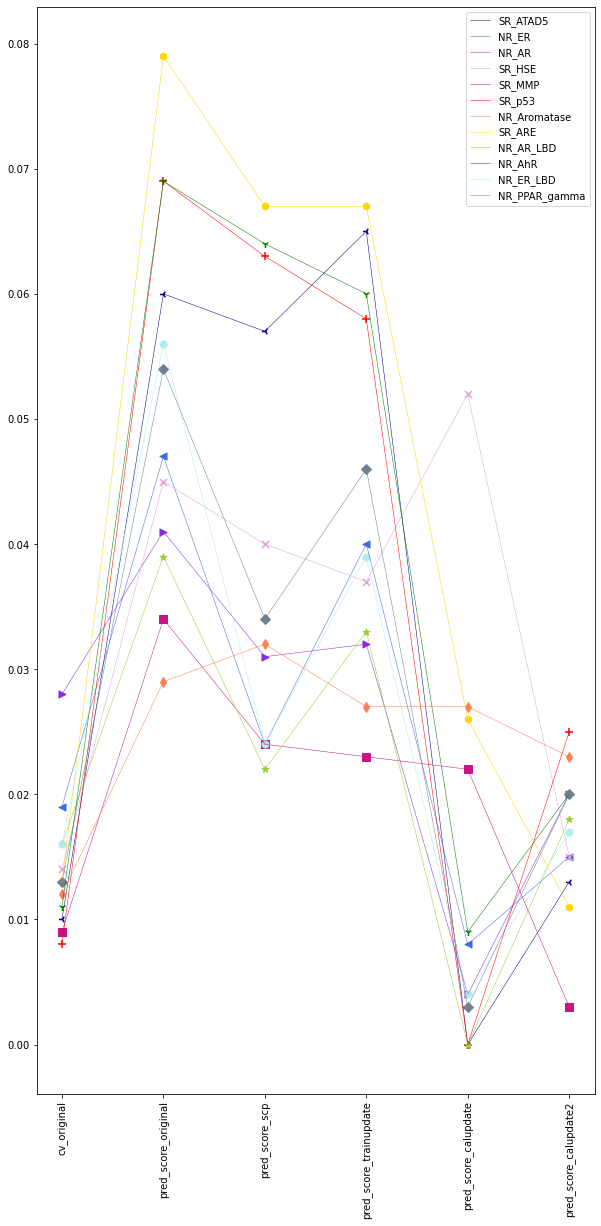

In [38]:
line_plot(rmsds_pos, strategies)